In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

def standardise(vec): return (vec - vec.mean()) / vec.std()
pd.set_option("display.max_rows", 500)

In [ ]:
# !curl "https://lsde-2021.cloud.databricks.com/files/group09/attack-day.parquet/*?o=3829739689441890" --output "../../data/small/attack-day-granular.parquet"

# !wget -r "https://lsde-2021.cloud.databricks.com/files/group09/attack-day.parquet/*?o=3829739689441890" -P "../../data/small/attack-day-titles"

In [ ]:
# !dbfs cp -r "dbfs:/FileStore/group09/attack-day-weekbefore.parquet" "../../data/big/attack-day2.parquet"

In [4]:
df = pd.read_parquet("../../data/big/attack-day.parquet")
df2 = pd.read_parquet("../../data/big/attack-day2.parquet")

In [5]:
df["date"] = pd.to_datetime(df["timestamp"], unit="s")
df2["date"] = pd.to_datetime(df2["timestamp"], unit="s")

In [13]:
df3 = pd.concat([df, df2])

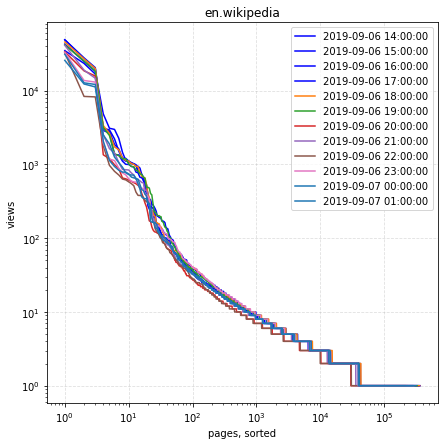

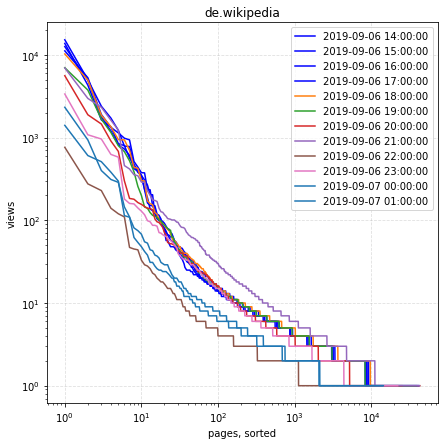

In [33]:
timestamps = df["timestamp"].unique()
domains = ["en.wikipedia", "de.wikipedia"]
attack = datetime.datetime(2019, 9, 6, 17, 40, 0)

for domain in domains:
    plt.figure(figsize=(7,7))
    for ts in timestamps:
        tmpdf = df[df["domain"] == domain]
        dist = tmpdf[tmpdf["timestamp"] == ts]["count"].sort_values(ascending=False)

        x = np.arange(len(dist))+1
        y = dist.to_numpy()

        color = "blue" if datetime.datetime.fromtimestamp(ts) < attack else f"C{max(0,datetime.datetime.fromtimestamp(ts).hour-17)}"
        label = datetime.datetime.fromtimestamp(ts)
        
        plt.plot(x, y, color=color, label=label)

    plt.grid(alpha=0.4, linestyle="--")

    plt.title(domain)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel("views")
    plt.xlabel("pages, sorted")
    plt.legend()
    plt.show()

In [172]:
hours = df3.date.dt.hour.unique()
df_grouped = df3.groupby(["date", "domain"])["count"].sum().reset_index()

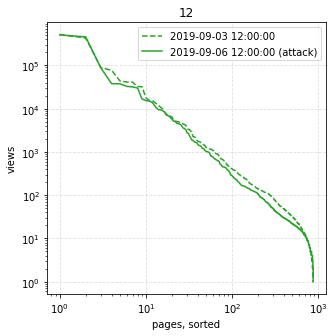

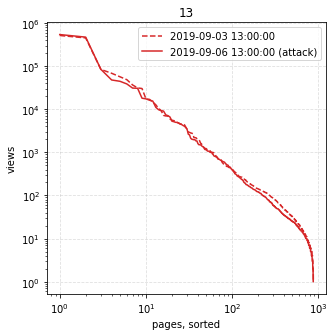

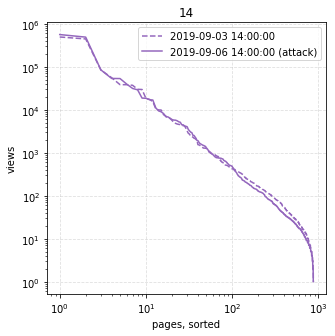

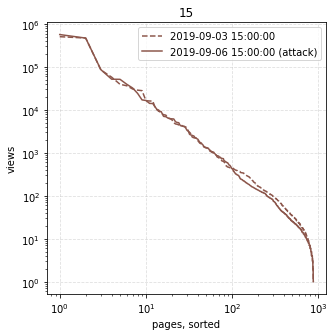

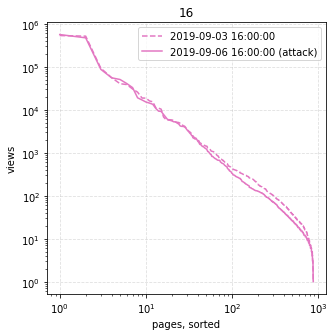

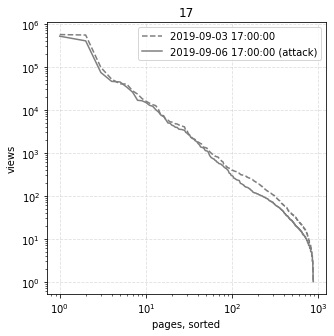

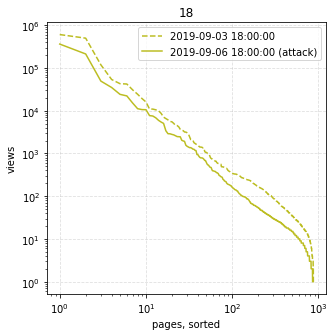

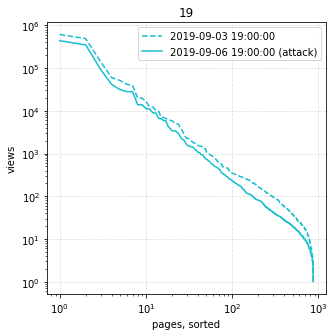

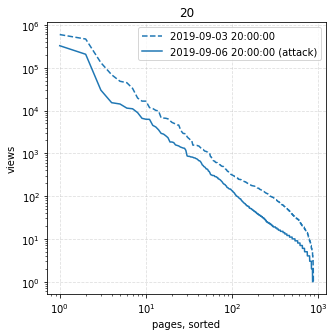

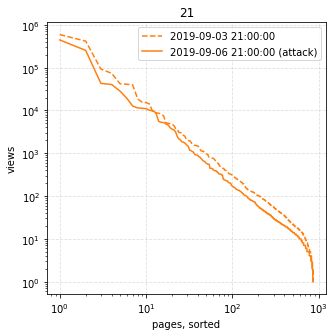

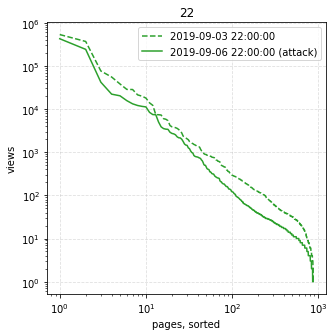

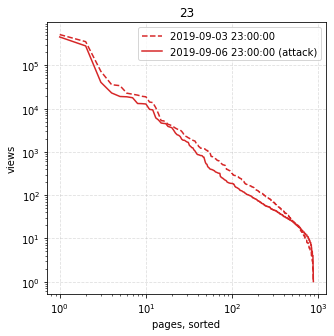

In [185]:
# ref = (np.linspace(0, 10**1, 10**3)**-1)*10**3

for hour in hours:
    plt.figure(figsize=(5,5))

    df_hour = df_grouped[df_grouped.date.dt.hour == hour]
    times = [pd.to_datetime(i) for i in df_hour.date.unique()]

    for time in times:

        df_time = df_hour[df_hour.date == time]
        views = df_time["count"].sort_values(ascending=False)

        x = np.arange(len(views))+1
        y = views.to_numpy()

        color = f"C{hour%10}"
        attack = (time.year == 2019 and time.month == 9 and time.day == 6)
        ls = "-" if attack else "--"
        label = f"{time} (attack)" if attack else time
        
        plt.plot(x, y, color=color, label=label, linestyle=ls)

    
    plt.grid(alpha=0.4, linestyle="--")
    plt.title(hour)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel("views")
    plt.xlabel("pages, sorted")
    plt.legend()
    plt.show()

In [567]:
hours = df3.date.dt.hour.unique()
domain = "de.wikipedia"
# domain = "ar.wikipedia"

df_domain = df3[df3["domain"] == domain]
ref = (np.linspace(0, 10**4, 10**4)**-1)*10**4

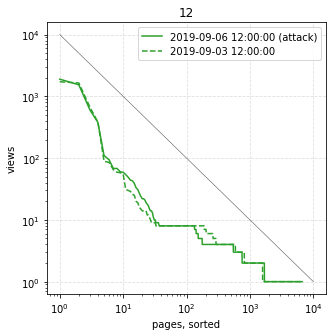

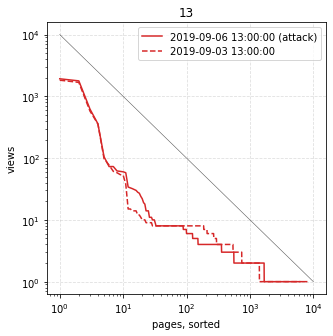

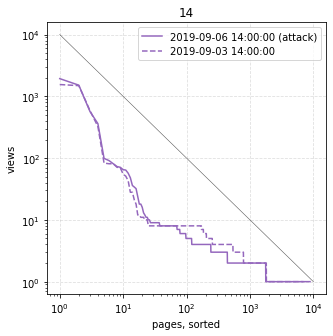

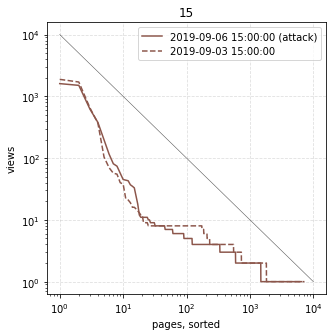

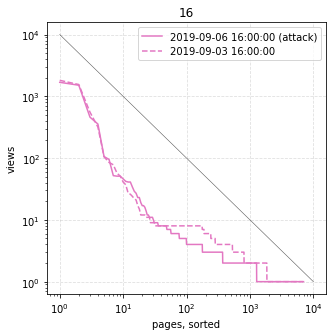

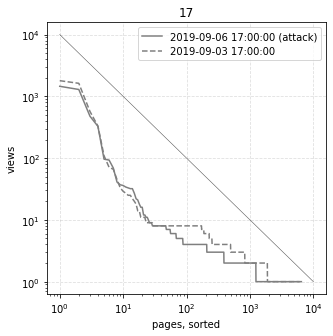

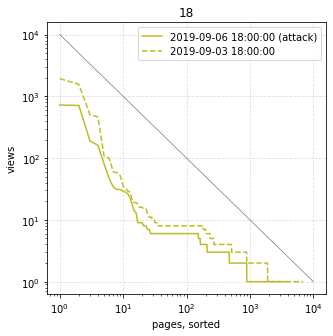

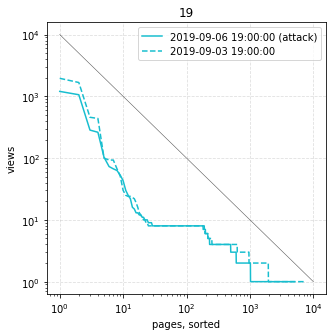

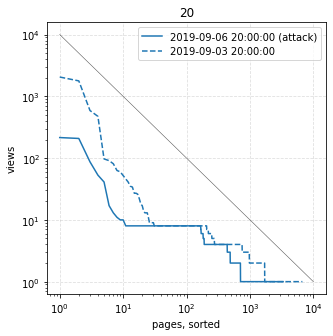

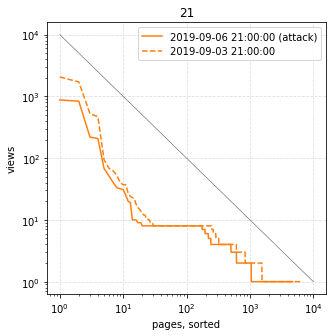

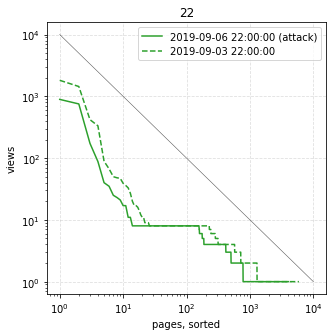

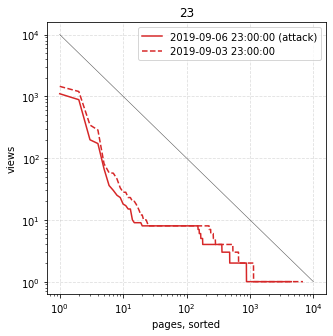

In [560]:
for hour in hours:
    plt.figure(figsize=(5,5))

    df_hour = df_domain[df_domain.date.dt.hour == hour]
    times = [pd.to_datetime(i) for i in df_hour.date.unique()]

    for time in times:

        df_time = df_hour[df_hour.date == time]
        views = df_time["count"].sort_values(ascending=False)

        x = np.arange(len(views))+1
        y = views.to_numpy()

        color = f"C{hour%10}"
        attack = (time.year == 2019 and time.month == 9 and time.day == 6)
        ls = "-" if attack else "--"
        label = f"{time} (attack)" if attack else time
        
        plt.plot(x, y, color=color, label=label, linestyle=ls)
        plt.plot(ref, color="black", alpha=0.4, linewidth=.5)

    
    plt.grid(alpha=0.4, linestyle="--")
    plt.title(hour)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel("views")
    plt.xlabel("pages, sorted")
    plt.legend()
    plt.show()

In [568]:
df_domain["identifier"] = df_domain.title + " " + df_domain.accessType + " " + df_domain.trafficType + " " + df_domain["date"].dt.hour.astype(str)
df_titletwice = df_domain[df_domain.groupby(["identifier"])["date"].transform("nunique")>1]

In [569]:
# confirm whether all entries on given day are the same
day1 = df_titletwice[df_titletwice.date == datetime.datetime(2019, 9, 6, 12, 0, 0)].sort_values("title")
day2 = df_titletwice[df_titletwice.date == datetime.datetime(2019, 9, 3, 12, 0, 0)].sort_values("title")
day1["title"].to_list() == day2["title"].to_list()

True

In [570]:
day1 = df_titletwice[df_titletwice.date == datetime.datetime(2019, 9, 6, 13, 0, 0)].sort_values("title")
day2 = df_titletwice[df_titletwice.date == datetime.datetime(2019, 9, 3, 13, 0, 0)].sort_values("title")
day1["title"].to_list() == day2["title"].to_list()

True

In [599]:
df_titletwice.sort_values(["date", "title"], inplace=True)

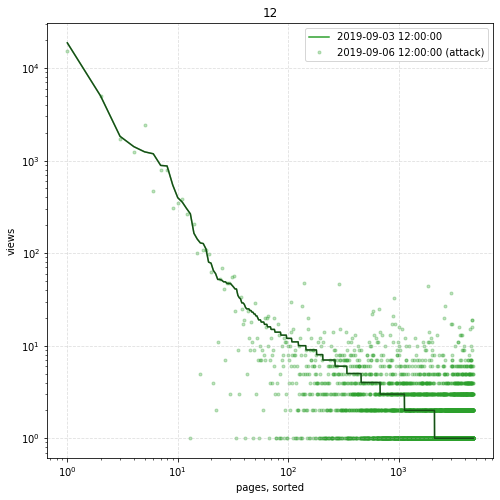

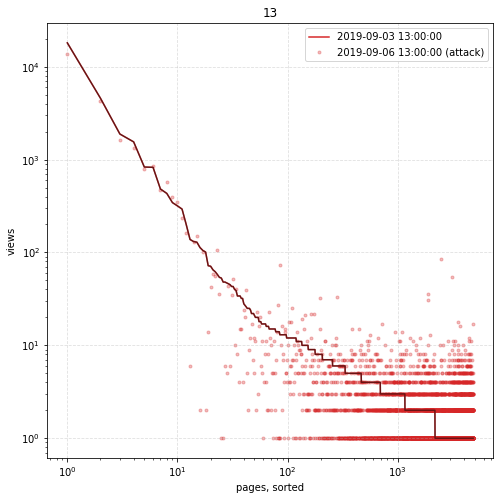

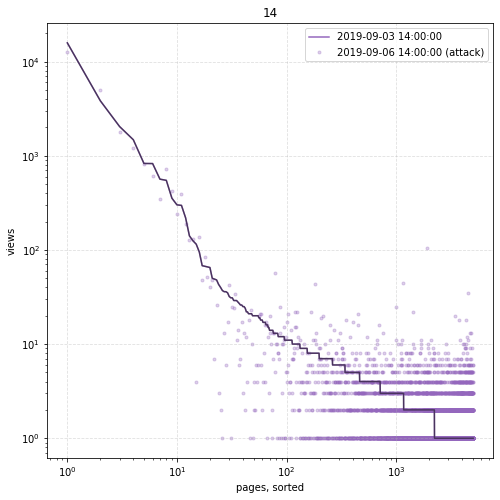

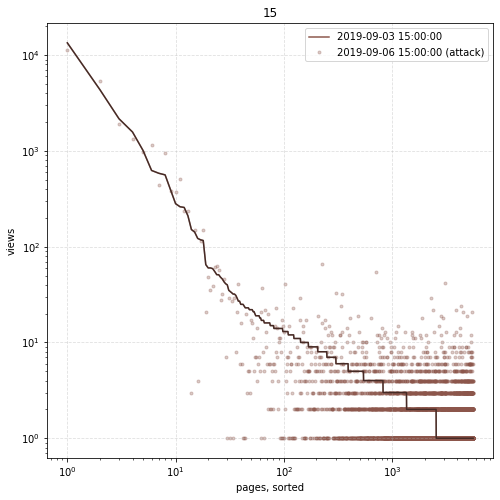

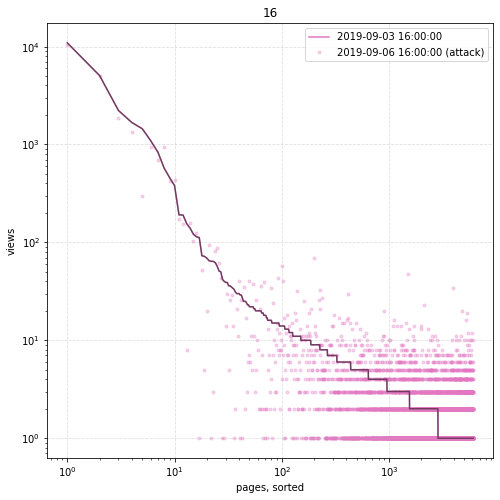

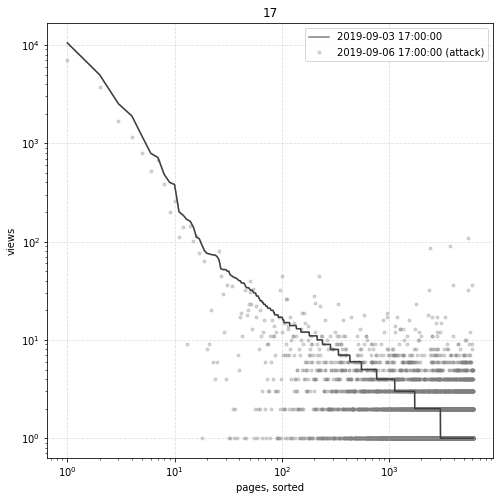

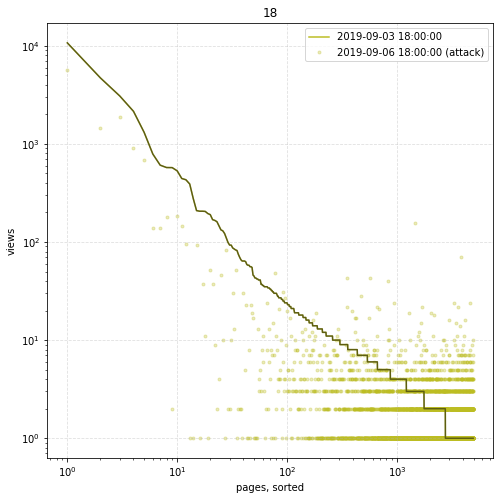

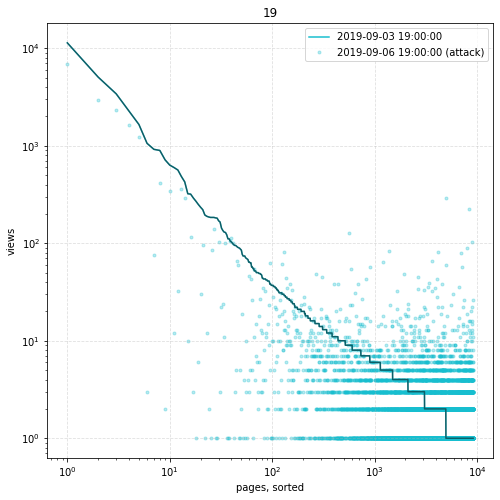

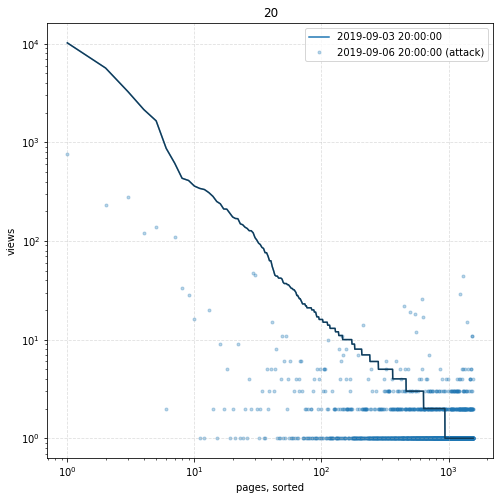

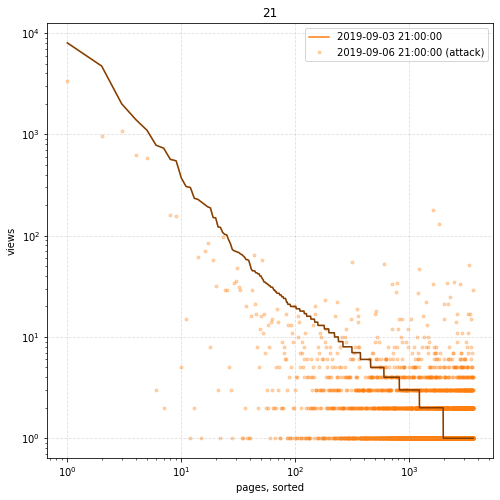

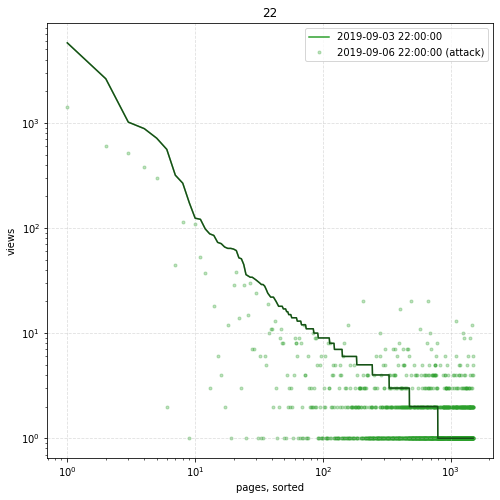

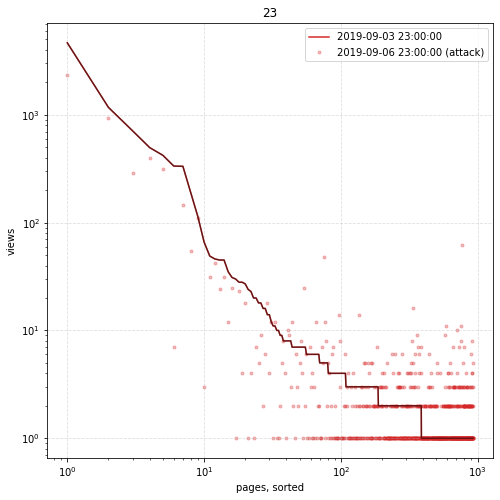

In [608]:
for hour in hours:
    plt.figure(figsize=(8,8))

    df_hour = df_titletwice[df_titletwice.date.dt.hour == hour]
    times = sorted([pd.to_datetime(i) for i in df_hour.date.unique()])

    time = times[0]  # pick the first time
    df_time = df_hour[df_hour.date == time]
    views_idx = np.argsort(df_time["count"])[::-1]

    for time in times:

        df_time = df_hour[df_hour.date == time]
        views = df_time["count"].to_numpy()[views_idx] # sort it
        titles = df_time["title"].to_numpy()[views_idx]

        # print(df_time[df_time.title == ])
        # for i,(v,t) in enumerate(zip(views, titles)):
        #     if t == "Überfall_auf_Polen":
        #         print(v)
        #         print(i)

        x = np.arange(len(views))+1
        y = views

        color = f"C{hour%10}"
        attack = (time.year == 2019 and time.month == 9 and time.day == 6)
        ls = "-" if attack else ":"
        label = f"{time} (attack)" if attack else time
        
        if not attack:
            plt.plot(x, y, color=color, label=label)
            plt.plot(x, y, color="black", alpha=0.5)
        else:
            plt.scatter(x, y, color=color, label=label, alpha=0.3, marker=".")

    plt.grid(alpha=0.4, linestyle="--")
    plt.title(hour)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel("views")
    plt.xlabel("pages, sorted")
    plt.legend()
    plt.show()
    # break

# DIfferent approach

In [502]:
df_ident = df_domain[["date", "identifier", "count"]]

In [503]:
df_ident

,date,identifier,count
3,2019-09-06 12:00:00,Spezial:Suche desktop user 12,15260
8,2019-09-06 12:00:00,Special:MyPage/toolserverhelferleinconfig.js d...,5013
16,2019-09-06 12:00:00,Spezial:Letzte_Änderungen desktop user 12,2399
25,2019-09-06 12:00:00,- mobile-web user 12,1723
38,2019-09-06 12:00:00,Spezial:Suche mobile-web user 12,1224
...,...,...,...
11858183,2019-09-03 23:00:00,GM-J-Plattform mobile-app user 23,1
11858184,2019-09-03 23:00:00,GP3-Serie mobile-app user 23,1
11858185,2019-09-03 23:00:00,GP3-Serie_2018 mobile-app user 23,1
11858186,2019-09-03 23:00:00,Gabardine mobile-app user 23,1


In [507]:
# df_time.append()

# df_idents = df

,domain,title,pageID,accessType,count,timestamp,trafficType,date,identifier
3,de.wikipedia,Spezial:Suche,-1,desktop,15260,1567771200,user,2019-09-06 12:00:00,Spezial:Suche desktop user 12
8,de.wikipedia,Special:MyPage/toolserverhelferleinconfig.js,-1,desktop,5013,1567771200,user,2019-09-06 12:00:00,Special:MyPage/toolserverhelferleinconfig.js d...
16,de.wikipedia,Spezial:Letzte_Änderungen,-1,desktop,2399,1567771200,user,2019-09-06 12:00:00,Spezial:Letzte_Änderungen desktop user 12
25,de.wikipedia,-,-1,mobile-web,1723,1567771200,user,2019-09-06 12:00:00,- mobile-web user 12
38,de.wikipedia,Spezial:Suche,-1,mobile-web,1224,1567771200,user,2019-09-06 12:00:00,Spezial:Suche mobile-web user 12
...,...,...,...,...,...,...,...,...,...
808533,de.wikipedia,Škoda_Octavia_III,-1,mobile-app,1,1567771200,user,2019-09-06 12:00:00,Škoda_Octavia_III mobile-app user 12
808534,de.wikipedia,Škoda_Scala,-1,mobile-app,1,1567771200,user,2019-09-06 12:00:00,Škoda_Scala mobile-app user 12
808535,de.wikipedia,Šolta,-1,mobile-app,1,1567771200,user,2019-09-06 12:00:00,Šolta mobile-app user 12
808536,de.wikipedia,Željko_Obradović,-1,mobile-app,1,1567771200,user,2019-09-06 12:00:00,Željko_Obradović mobile-app user 12


In [510]:
idents = df_hour["identifier"].unique()

In [512]:
idents_df = 
idents_df["count"] = ""
idents_df["pageID"] = -1
idents_df["pageID"] = -1

idents_df

,identifier,title
0,Spezial:Suche desktop user 12,
1,Special:MyPage/toolserverhelferleinconfig.js d...,
2,Spezial:Letzte_Änderungen desktop user 12,
3,- mobile-web user 12,
4,Spezial:Suche mobile-web user 12,
...,...,...
74501,Žilina mobile-app user 12,
74502,Țuică mobile-app user 12,
74503,Δ-Valerolacton mobile-app user 12,
74504,…_And_Justice_for_All mobile-app user 12,


In [516]:
times

[Timestamp('2019-09-03 13:00:00'), Timestamp('2019-09-06 13:00:00')]

In [558]:
df_domain

,domain,title,pageID,accessType,count,timestamp,trafficType,date,identifier
3,de.wikipedia,Spezial:Suche,-1,desktop,15260,1567771200,user,2019-09-06 12:00:00,Spezial:Suche desktop user 12
8,de.wikipedia,Special:MyPage/toolserverhelferleinconfig.js,-1,desktop,5013,1567771200,user,2019-09-06 12:00:00,Special:MyPage/toolserverhelferleinconfig.js d...
16,de.wikipedia,Spezial:Letzte_Änderungen,-1,desktop,2399,1567771200,user,2019-09-06 12:00:00,Spezial:Letzte_Änderungen desktop user 12
25,de.wikipedia,-,-1,mobile-web,1723,1567771200,user,2019-09-06 12:00:00,- mobile-web user 12
38,de.wikipedia,Spezial:Suche,-1,mobile-web,1224,1567771200,user,2019-09-06 12:00:00,Spezial:Suche mobile-web user 12
...,...,...,...,...,...,...,...,...,...
11858183,de.wikipedia,GM-J-Plattform,-1,mobile-app,1,1567551600,user,2019-09-03 23:00:00,GM-J-Plattform mobile-app user 23
11858184,de.wikipedia,GP3-Serie,-1,mobile-app,1,1567551600,user,2019-09-03 23:00:00,GP3-Serie mobile-app user 23
11858185,de.wikipedia,GP3-Serie_2018,-1,mobile-app,1,1567551600,user,2019-09-03 23:00:00,GP3-Serie_2018 mobile-app user 23
11858186,de.wikipedia,Gabardine,-1,mobile-app,1,1567551600,user,2019-09-03 23:00:00,Gabardine mobile-app user 23


                                  identifier                date  count
74332       special:search desktop spider 12 2019-09-03 12:00:00     11
74439  Überfall_auf_Polen mobile-app user 12 2019-09-03 12:00:00     33
                          identifier                date  count
74327  Züriputsch mobile-app user 12 2019-09-06 12:00:00     20
74336     wiki.phtml desktop user 12 2019-09-06 12:00:00     14
74377       Élite mobile-app user 12 2019-09-06 12:00:00     15
74414  Österreich mobile-app user 12 2019-09-06 12:00:00     12


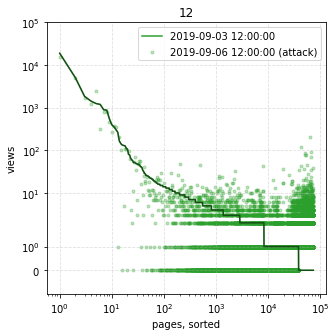

In [584]:
for hour in hours:
    plt.figure(figsize=(5,5))

    # get all entries on this hour, no matter what day
    df_hour = df_domain[df_domain.date.dt.hour == hour][["date", "identifier", "count"]]

    # get all dates where we have this hour
    times = sorted([pd.to_datetime(i) for i in df_hour.date.unique()])

    # get all unique identifiers
    idents = df_hour["identifier"].unique()

    df_time_list = []

    for i, time in enumerate(times):

        df_time = df_hour[df_hour.date == time]

        df_all_idents = pd.DataFrame(idents).rename(columns={0:"identifier"})
        df_all_idents["date"] = time
        df_all_idents["count"] = 0

        df_time_all = pd.concat([df_time, df_all_idents], join="outer").groupby(["identifier", "date"]).sum().reset_index()

        if i == 0:
            # first one we sort
            views_idx = np.argsort(df_time_all["count"])[::-1]

        views = df_time_all["count"].to_numpy()[views_idx] # sort it
        titles = df_time_all["identifier"].to_numpy()[views_idx] # sort it

        df_time_all_cut = df_time_all[-500:]
        # print(df_time_all_cut)

        print(df_time_all_cut[df_time_all_cut["count"]>10])


        x = np.arange(len(views))+1
        y = views
        color = f"C{hour%10}"
        attack = (time.year == 2019 and time.month == 9 and time.day == 6)
        label = f"{time} (attack)" if attack else time
        
        if i == 0:
            plt.plot(x, y, color=color, label=label, linestyle="-")
            plt.plot(x, y, color="black", alpha=0.5)
        else:

            plt.scatter(x,y, color=color, label=label, alpha=0.3, marker=".")

    plt.grid(alpha=0.4, linestyle="--")
    plt.title(hour)
    plt.xscale("log")
    plt.yscale("symlog")
    plt.ylim(-1, 10**5)
    plt.ylabel("views")
    plt.xlabel("pages, sorted")
    plt.legend()
    plt.show()
    break

In [588]:
df_titletwice[df_titletwice.title == "Überfall_auf_Polen"]

,domain,title,pageID,accessType,count,timestamp,trafficType,date,identifier
24056,de.wikipedia,Überfall_auf_Polen,-1,mobile-app,3,1567771200,user,2019-09-06 12:00:00,Überfall_auf_Polen mobile-app user 12
1021922,de.wikipedia,Überfall_auf_Polen,-1,mobile-app,5,1567774800,user,2019-09-06 13:00:00,Überfall_auf_Polen mobile-app user 13
2097459,de.wikipedia,Überfall_auf_Polen,-1,mobile-app,6,1567778400,user,2019-09-06 14:00:00,Überfall_auf_Polen mobile-app user 14
4530288,de.wikipedia,Überfall_auf_Polen,-1,mobile-app,1,1567785600,user,2019-09-06 16:00:00,Überfall_auf_Polen mobile-app user 16
5430067,de.wikipedia,Überfall_auf_Polen,-1,mobile-app,5,1567789200,user,2019-09-06 17:00:00,Überfall_auf_Polen mobile-app user 17
6418625,de.wikipedia,Überfall_auf_Polen,-1,mobile-app,2,1567792800,user,2019-09-06 18:00:00,Überfall_auf_Polen mobile-app user 18
6995328,de.wikipedia,Überfall_auf_Polen,-1,mobile-app,7,1567796400,user,2019-09-06 19:00:00,Überfall_auf_Polen mobile-app user 19
8383845,de.wikipedia,Überfall_auf_Polen,-1,mobile-app,2,1567803600,user,2019-09-06 21:00:00,Überfall_auf_Polen mobile-app user 21
9730398,de.wikipedia,Überfall_auf_Polen,-1,mobile-app,4,1567810800,user,2019-09-06 23:00:00,Überfall_auf_Polen mobile-app user 23
730,de.wikipedia,Überfall_auf_Polen,-1,mobile-app,33,1567512000,user,2019-09-03 12:00:00,Überfall_auf_Polen mobile-app user 12


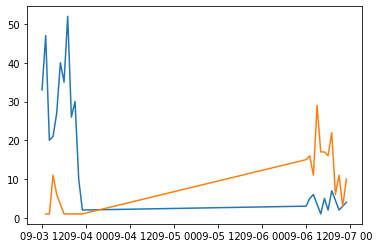

In [585]:
interesting = df_domain[df_domain["title"] == "Überfall_auf_Polen"].sort_values("date")
plt.plot(interesting["date"], interesting["count"])
interesting = df_domain[df_domain["title"] == "Élite"].sort_values("date")
plt.plot(interesting["date"], interesting["count"])
# print(interesting)

In [536]:
df_time_all

,identifier,date,count
0,(10932)_Rebentrost desktop spider 12,2019-09-06 12:00:00,0
1,(1294)_Antwerpia desktop spider 12,2019-09-06 12:00:00,0
2,(1635)_Bohrmann desktop spider 12,2019-09-06 12:00:00,1
3,(2564)_Kayala desktop spider 12,2019-09-06 12:00:00,0
4,(2867)_Šteins mobile-app user 12,2019-09-06 12:00:00,1
...,...,...,...
74501,’Till_I_Collapse mobile-app user 12,2019-09-06 12:00:00,2
74502,’s-Hertogenbosch mobile-app user 12,2019-09-06 12:00:00,6
74503,…_And_Justice_for_All mobile-app user 12,2019-09-06 12:00:00,0
74504,…_And_Then_There_Were_Three_… mobile-app user 12,2019-09-06 12:00:00,0


In [534]:
series_title_count

,identifier,date,count
0,(10932)_Rebentrost desktop spider 12,2019-09-06 12:00:00,0
1,(1294)_Antwerpia desktop spider 12,2019-09-06 12:00:00,0
2,(1635)_Bohrmann desktop spider 12,2019-09-06 12:00:00,1
3,(2564)_Kayala desktop spider 12,2019-09-06 12:00:00,0
4,(2867)_Šteins mobile-app user 12,2019-09-06 12:00:00,1
...,...,...,...
74501,’Till_I_Collapse mobile-app user 12,2019-09-06 12:00:00,2
74502,’s-Hertogenbosch mobile-app user 12,2019-09-06 12:00:00,6
74503,…_And_Justice_for_All mobile-app user 12,2019-09-06 12:00:00,0
74504,…_And_Then_There_Were_Three_… mobile-app user 12,2019-09-06 12:00:00,0


In [526]:
pd.concat([df_time, df_all_idents], join="outer").groupby(["identifier", "date"])["count"].sum()

identifier                                             date               
(1157)_Arabia desktop spider 13                        2019-09-06 13:00:00    1
(136199)_Eris mobile-app user 13                       2019-09-06 13:00:00    5
(1929)_Kollaa desktop spider 13                        2019-09-06 13:00:00    1
(379)_Huenna desktop spider 13                         2019-09-06 13:00:00    1
(4313)_Bouchet desktop spider 13                       2019-09-06 13:00:00    1
                                                                             ..
’Ndrangheta mobile-app user 13                         2019-09-06 13:00:00    0
’s-Hertogenbosch mobile-app user 13                    2019-09-06 13:00:00    1
’solid_–_die_sozialistische_Jugend mobile-app user 13  2019-09-06 13:00:00    0
…_And_Justice_for_All mobile-app user 13               2019-09-06 13:00:00    0
…_Jahr_2022_…_die_überleben_wollen mobile-app user 13  2019-09-06 13:00:00    2
Name: count, Length: 74257, dtype: int64

# IDEA 2: argsort on day before attack, then use these idx to sort on attack day --> outliers will be spikes
--> a bit more involved since we the length of vector changes... so what we can do is make it so each topics appears in both vectors, possibly with count = 0, just so vectors have same length

# IDEA 3: do the same on a domain basis, so e.g. all domain views per hour, for all existing domains, should be a similar plot
--> then pick out the weird domains, and inspect them further with the above way

# IDEA 4: do this exact method on random other days (and few days before it) to make it a bit more scientific

# IDEA 5: we can also look at the distribution and compute statistics

## Goal: search for topics that are usually ranked lower

How could we do it?
- compute stdev of all rankings or views --> no, because this is same std np.std([1,1000]), np.std([1000,2000]), however a topic
- std of views

We can reduce the space of titles to look for greatly by just focusing on titles that got x amount of views (x has to be small though) during the day/time of the attack

In [90]:
print(np.std([np.log(1), np.log(1000)]))
print(np.std([np.log(1000), np.log(1000*1000)]))

3.4538776394910684
3.4538776394910684


In [107]:
fil = (df.title == "Apple") & (df.domain == "en.wikipedia")# & (df.accessType == "desktop") & (df.trafficType == "user")

In [129]:
# df3[df3.title == "Apple"]

In [131]:
np.std(np.log()), np.std(np.log([1, 1, 2, 10000]))

(0.29288125904887624, 3.898430977834643)

In [133]:
dist1 = np.array([10000, 15000, 20000, 10000])
dist2 = np.array([1, 1, 2, 10000])

standardise(dist1), standardise(dist2)

(array([-0.90453403,  0.30151134,  1.50755672, -0.90453403]),
 array([-0.57742726, -0.57742726, -0.57719629,  1.7320508 ]))

---

# Experiment: saving data efficiently

In [327]:
dist = df[df.timestamp == 1567771200]["count"].to_numpy()  # take data from one hour
dist

array([34982, 23476, 16830, ...,     1,     1,     1], dtype=int32)

In [453]:
distdic = {}
for i in dist:
    try:
        distdic[i] += 1
    except KeyError:
        distdic[i] = 1

disttuplelist = [(k,v) for k,v in distdic.items()]

disttuplearray = np.array(disttuplelist, dtype="int32")

distdf = pd.DataFrame.from_dict(distdic, orient="index").reset_index().rename(columns={"index":"keys", 0:"views"})

# saving
distdf.to_csv("test/dist.csv", index=False)
distdf.to_csv("test/dist.csv.gz", index=False, compression="gzip")
np.save("test/dist2", disttuplearray)
np.save("test/dist", dist)

!ls -lh test

total 8232
-rw-r--r--  1 charelfelten  staff   1.8K Oct 24 22:55 dist.csv
-rw-r--r--  1 charelfelten  staff   804B Oct 24 22:55 dist.csv.bz2
-rw-r--r--  1 charelfelten  staff   800B Oct 24 22:55 dist.csv.gz
-rw-r--r--  1 charelfelten  staff   3.9M Oct 24 22:55 dist.npy
-rw-r--r--  1 charelfelten  staff   2.5K Oct 24 22:55 dist2.npy
